# PMAP Labs Feature Engineering
Created: December 12, 2022  
*Last Modified: Feburary 15, 2023*  
Total runtime: 1547 sec

This notebook explores what labs we have, their prevalence, and to identify which of these would be important for our models.
After the initial analysis is done, the results would be used to generate the lab-based features.
* Per discussion w/ Dr. F on 2/9: Lab groups need to be redefined.

Author: Vina Ro

In [65]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

In [66]:
st = time.time()

In [67]:
# Set filepath
file_path = Path('PMAP_Final_Cohort_Vina.ipynb').resolve()
data_path1 = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')
data_path2 = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-230117-update')

In [68]:
# Files generated from PMAP_Final_Cohort_Vina.ipynb
CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv', parse_dates = ['hosp_admsn_time','hosp_disch_time'])
df_selected_labs   = pd.read_csv("LabsRelevantInfo.csv")
labs               = pd.read_csv(data_path2 / 'labs.csv', parse_dates = ['order_time','result_time','specimen_taken_time','specimen_recv_time'])

# Import dictionaries (no patient data)
d_component        = pd.read_csv(data_path1 / 'd_component.csv')

/home/idies/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (25,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/idies/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (21,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [69]:
st1 = time.time()
display(labs.head())
print(labs.shape)

,osler_sid,pat_enc_csn_sid,order_proc_sid,proc_id,proc_cat_id,sensitive_yn,order_type,lab_group,resulting_lab,order_time,...,reference_low,reference_high,reference_unit,result_sub_idn,res_comp_singleline,res_comp_multiline,result_in_range_yn,lrr_based_organ_id,data_type,loinc_code
0,2CB2F005-F9B7-4CC0-83AB-BFBFA3DCED12,1000408842,11101714,64630.0,107,N,Lab,lab,JHH BMC LABS,2019-06-23 05:06:00,...,0.5,2,mmol/L,NaN,NaN,NaN,NaN,NaN,Number,32693-4
1,2CB2F005-F9B7-4CC0-83AB-BFBFA3DCED12,1000408842,13716683,107512.0,81,N,Lab,lab,JOHNS HOPKINS MEDICAL LABS (J.H.M.L.),2019-09-01 23:45:00,...,71,99,mg/dL,NaN,NaN,NaN,NaN,NaN,Number,41653-7
2,2CB2F005-F9B7-4CC0-83AB-BFBFA3DCED12,1000408842,7923601,107512.0,81,N,Lab,lab,JOHNS HOPKINS MEDICAL LABS (J.H.M.L.),2019-09-08 19:35:00,...,71,99,mg/dL,NaN,NaN,NaN,NaN,NaN,Number,41653-7
3,2CB2F005-F9B7-4CC0-83AB-BFBFA3DCED12,1000408842,9520997,90001.0,109,N,Lab,lab,JHH BMC LABS,2019-10-08 14:01:00,...,40,70,%,NaN,NaN,NaN,NaN,NaN,Number,770-8
4,2CB2F005-F9B7-4CC0-83AB-BFBFA3DCED12,1000387234,12591074,177426.0,105,N,Lab,lab,JHH BMC LABS,2019-11-17 06:31:00,...,0,27,/uL,NaN,NaN,NaN,NaN,NaN,Number,798-9


(51299457, 35)


### Subsetting from labs dataframe
1. Get labs of pat_enc_csn_sids related to a CHF hospital stay.
2. Keep only rows of data where the sample is collected during each hospital stay, i.e. btw hosp_admsn_time and hosp_disch_time.

In [70]:
CHF_labs = labs[labs['osler_sid'].isin(CHF_hosp_icu_stays['osler_sid'])]
CHF_labs = CHF_labs.sort_values(['osler_sid','specimen_taken_time'])
display(CHF_labs.head())
print(CHF_labs.shape)

,osler_sid,pat_enc_csn_sid,order_proc_sid,proc_id,proc_cat_id,sensitive_yn,order_type,lab_group,resulting_lab,order_time,...,reference_low,reference_high,reference_unit,result_sub_idn,res_comp_singleline,res_comp_multiline,result_in_range_yn,lrr_based_organ_id,data_type,loinc_code
115755,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,5937266,1760.0,109,N,Lab,lab,JHH BMC LABS,2017-12-10 17:22:00,...,NaN,NaN,Seconds,NaN,NaN,NaN,NaN,NaN,Number,3173-2
115834,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,11552622,90001.0,109,N,Lab,lab,JHH BMC LABS,2017-12-10 17:22:00,...,NaN,NaN,K/cu mm,NaN,NaN,NaN,NaN,NaN,Number,33256-9
115895,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,10517644,682.0,109,N,Lab,lab,JHH BMC LABS,2017-12-10 17:22:00,...,NaN,NaN,g/dL,NaN,NaN,NaN,NaN,NaN,Number,1751-7
115910,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,10517644,682.0,109,N,Lab,lab,JHH BMC LABS,2017-12-10 17:22:00,...,NaN,NaN,mmol/L,NaN,NaN,NaN,NaN,NaN,Number,2027-1
115918,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,10517644,682.0,109,N,Lab,lab,JHH BMC LABS,2017-12-10 17:22:00,...,NaN,NaN,mg/dL,NaN,NaN,NaN,NaN,NaN,Number,2160-0


(13675340, 35)


In [71]:
merged = pd.merge(left = CHF_hosp_icu_stays, right = CHF_labs, how = 'inner', on = ['osler_sid','pat_enc_csn_sid'])
CHF_labs = merged[merged.specimen_taken_time.between(merged.hosp_admsn_time, merged.hosp_disch_time)]

In [72]:
CHF_labs.head()

,osler_sid,pat_enc_csn_sid,hosp_admsn_time,hosp_disch_time,labels,order_proc_sid,proc_id,proc_cat_id,sensitive_yn,order_type,...,reference_low,reference_high,reference_unit,result_sub_idn,res_comp_singleline,res_comp_multiline,result_in_range_yn,lrr_based_organ_id,data_type,loinc_code
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,5937266,1760.0,109,N,Lab,...,NaN,NaN,Seconds,NaN,NaN,NaN,NaN,NaN,Number,3173-2
1,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,11552622,90001.0,109,N,Lab,...,NaN,NaN,K/cu mm,NaN,NaN,NaN,NaN,NaN,Number,33256-9
2,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,NaN,NaN,g/dL,NaN,NaN,NaN,NaN,NaN,Number,1751-7
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,NaN,NaN,mmol/L,NaN,NaN,NaN,NaN,NaN,Number,2027-1
4,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,NaN,NaN,mg/dL,NaN,NaN,NaN,NaN,NaN,Number,2160-0


#### After this, the information was combined, and annotated by hand.  
I looked at the distributions of the 'ord_value' column to determine whether a field was 
1. **'numerical'** : All numbers, but allowed inclusion of 'see comments' and similar statements since these were found in all labs)
2. **'categorical'** : Responses belonged to a set of ranges or strings)
3. **'mixed'** : Usually numerical categories with some '<x' or 'x-y' type values).

By looking at the distributions of the specimen type / specimen source columns, as well as the component names, I allocated 'lab_custom_group' names to the labs.  
If a lab contains all 'specimen_type' as 'blood', it begins with 'blood_<lab_name>'.  
If a lab contained 'specimen_type' as ['Blood', nan], I assumed all the specimens were blood for that particular lab_id (component_id in PMAP), and named it as 'blood_<lab_name>'.  
If a lab had more than one source (instruments, bacteria cultures etc.), either it has no prefix, or a prefix of 'mixed'

##### This is stored in "LabsRelevantInfo.csv"

In [73]:
labs_relevant_info = pd.read_csv("LabsRelevantInfo.csv")
labs_relevant_info.head()

,component_id,component_name,lab_common_name,lab_external_name,num_stay,prop_stay,component_datatype,specimen_type_AND/OR_source,lab_custom_group,notes
0,2000000103,ANION GAP,ANION GAP,Anion Gap,2283,0.996943,numerical,OR,blood_anion_gap,NaN
1,2000000104,BUN / CREATININE RATIO,BUN / CREAT RATIO,BUN / Creatinine Ratio,2283,0.996943,numerical,OR,blood_bun_creatinine_ratio,NaN
2,2000000102,CALCIUM,CALCIUM,Calcium,2283,0.996943,numerical,OR,blood_calcium,NaN
3,2000000098,CARBON DIOXIDE,CO2,Carbon Dioxide,2283,0.996943,numerical,OR,blood_carbon_dioxide,NaN
4,2000000097,CHLORIDE,CHLORIDE,Chloride,2283,0.996943,numerical,OR,blood_chloride,NaN


### Get Proportion of Each Lab Custom Group in our Cohort
Find the number & proportion of ICU stays from the cohort associated with each vent_set meas_id.  
Store the information in a .csv

In [74]:
total_stay = CHF_hosp_icu_stays.shape[0]
num_stays = []
prop_stays = []
var_names = []

for var in labs_relevant_info['lab_custom_group'].unique():
    meas_ids = labs_relevant_info[labs_relevant_info['lab_custom_group'] == var]['component_id']
    # Find the number & proportion of ICU stays from the cohort for each lab custom group.

    cur_subset = CHF_labs[CHF_labs['component_id'].isin(meas_ids)]
    num_stay = cur_subset.pat_enc_csn_sid.nunique()

    num_stays.append(num_stay)
    prop_stays.append(round((num_stay / total_stay), 4))
    var_names.append(var)

labs_prevalence = pd.DataFrame()
labs_prevalence['lab_custom_group'] = var_names
labs_prevalence['num_stays']= num_stays
labs_prevalence['prevalence'] = prop_stays

display(labs_prevalence.head())

labs_info = pd.merge(left = labs_relevant_info.drop(['num_stay','prop_stay'], axis = 1), right = labs_prevalence, on = 'lab_custom_group', how = 'left')
labs_info.to_csv('LabsInfo.csv', index = False)
labs_info.head()

,lab_custom_group,num_stays,prevalence
0,blood_anion_gap,4468,0.9955
1,blood_bun_creatinine_ratio,4468,0.9955
2,blood_calcium,4468,0.9955
3,blood_carbon_dioxide,4468,0.9955
4,blood_chloride,4468,0.9955


,component_id,component_name,lab_common_name,lab_external_name,component_datatype,specimen_type_AND/OR_source,lab_custom_group,notes,num_stays,prevalence
0,2000000103,ANION GAP,ANION GAP,Anion Gap,numerical,OR,blood_anion_gap,NaN,4468,0.9955
1,2000000104,BUN / CREATININE RATIO,BUN / CREAT RATIO,BUN / Creatinine Ratio,numerical,OR,blood_bun_creatinine_ratio,NaN,4468,0.9955
2,2000000102,CALCIUM,CALCIUM,Calcium,numerical,OR,blood_calcium,NaN,4468,0.9955
3,2000000098,CARBON DIOXIDE,CO2,Carbon Dioxide,numerical,OR,blood_carbon_dioxide,NaN,4468,0.9955
4,2000000097,CHLORIDE,CHLORIDE,Chloride,numerical,OR,blood_chloride,NaN,4468,0.9955


In [195]:
labs_info.shape

(311, 10)

## Data Cleaning

##### Special Treatment for Labs, discussed w/ Dr. F
1. rare_labs: labs to **keep** which usually have a lower prevalence but are associated w/ CHF
2. skipped_labs: labs to **delete** which are irrelevant / distribution doesnt make sense

In [568]:
print('Percentage of missing values in CHF_labs: {:.4f} % '.format(CHF_labs.ord_num_value.isnull().sum() / CHF_labs.shape[0]))
CHF_labs = CHF_labs[~CHF_labs['ord_num_value'].isnull()]

Percentage of missing values in CHF_labs: 0.0043 % 


In [75]:
rare_labs = ['blood_a1c_hemoglobin', 'blood_c_reactive_protein','blood_erythrocyte_sedimentation_rate',
             'blood_thyroid_stimulating_hormone','blood_thyroxine_t4_free']

skipped_labs = ['urine_bilirubin_qualitative', 'urine_ketones_qualitative', 'blood_antibody_screen', 'urine_nitrite',
                'urine_crystals', 'urine_glucose_semiquant', 'blood_nucleated_rbc_number', 'blood_nova_instrument',
                'add_on_test_request_lab', 'blood_specimen_source']

### 1. Prepare df
- Exclude preliminary & incomplete results
- Pick out labs which usually have a lower prevalence that are associated w/ CHF ####---ASK---####
- Retain only labs with a prevalence of at least 80%
- Divide labs data into numerical and categorical

In [569]:
df_labs = CHF_labs.merge(labs_info[['component_id','component_name','component_datatype','lab_custom_group','prevalence']], how = 'left', on = 'component_id')
print(df_labs.lab_custom_group.nunique())
df_labs = df_labs[~df_labs['result_status'].isin(['Incomplete','Preliminary'])]
# First pick out labs which usually have a lower prevalence that are associated w/ CHF
df_labs = df_labs[~df_labs['lab_custom_group'].isin(skipped_labs)]
print(df_labs.lab_custom_group.nunique())
# df_labs_rare = df_labs[df_labs['lab_custom_group'].isin(rare_labs)]
# df_labs = pd.concat([df_labs, df_labs_rare], axis = 0)

# df_labs.to_csv('CHF_labs.csv', index = False)
# Retain only labs with a prevalence of at least 80%
df_labs = df_labs[df_labs['prevalence'] >= 0.8]
print(df_labs.lab_custom_group.nunique())

# df_labs.to_csv('CHF_labs_prev_0.8.csv', index = False)

df_labs_categorical = df_labs[df_labs['component_datatype'] == 'categorical']
print(df_labs_categorical.lab_custom_group.nunique())
df_labs_numerical = df_labs[df_labs['component_datatype'] == 'numerical']
print(df_labs_numerical.lab_custom_group.nunique())

204
194
56
2
54


In [191]:
df_labs.component_datatype.unique()

array(['numerical', 'categorical'], dtype=object)

In [207]:
print(labs_info[labs_info['component_datatype'] == 'categorical'].lab_custom_group.nunique())

67


### 2. Create unit conversion dictionary for each lab_custom_group
Used in cleaning numerical labs

In [77]:
# Drop rows where reference units are null
df_labs_numerical = df_labs_numerical[~df_labs_numerical['reference_unit'].isnull()]
df_labs_numerical['reference_unit_cleaned'] = df_labs_numerical['reference_unit'].str.replace('\s', '').str.replace('[', '').str.replace(']', '') #.str.lower()

df = df_labs_numerical.drop_duplicates(['lab_custom_group','reference_unit_cleaned']).sort_values('lab_custom_group')

## Case 1: Find labs that have over 1 unit documented and replace all w/ SI units
temp = df.groupby('lab_custom_group', as_index = False)['reference_unit'].count().sort_values('reference_unit', ascending = False)
mixmatched_labs = list(temp[temp['reference_unit'] > 1]['lab_custom_group'])   # len(mixmatched_labs) = 5
df_mixmatched_labs = df[df['lab_custom_group'].isin(mixmatched_labs)][['lab_custom_group','reference_unit_cleaned']]
print('Labs that have over one unit documented:')
display(df_mixmatched_labs)

# Create df to store unit conversion info
df_unit_convert = df_mixmatched_labs[df_mixmatched_labs['reference_unit_cleaned'] != 'mmol/L'].copy()
df_unit_convert['converted_unit'] = 'mmol/L'
df_unit_convert['convert_factor'] = 1

## Case 2: Change K/cu mm and M/cu mm to cu mm
print('Labs that need to be converted to /cumm:')
temp = df[df['reference_unit_cleaned'].str.contains('cumm')][['lab_custom_group','reference_unit_cleaned']]
display(temp)
temp['converted_unit'] = '/cumm'
temp['convert_factor'] = np.where(temp['reference_unit_cleaned'] == 'K/cumm', 1000, 1000000)
df_unit_convert = pd.concat([df_unit_convert, temp])

## Case 3: Change U/L to ukat/L (SI units)
print('Labs where U/L need to be converted to ukat/L:')
temp = df[df['reference_unit_cleaned'] == 'U/L'][['lab_custom_group','reference_unit_cleaned']]
display(temp)
temp['converted_unit'] = 'µkat/L'
temp['convert_factor'] = 0.0166
df_unit_convert = pd.concat([df_unit_convert, temp])

# Case 4: Change g/dL to g/L (SI units)
temp = df[df['reference_unit_cleaned'] == 'g/dL'][['lab_custom_group','reference_unit_cleaned']]
print('Labs where g/dL need to be converted to g/L:')
display(temp)
temp['converted_unit'] = 'g/L'
temp['convert_factor'] = 10
df_unit_convert = pd.concat([df_unit_convert, temp])

# Case 5:Change mg/dL to mol units manually
temp = df[df['reference_unit_cleaned'] == 'mg/dL'][['lab_custom_group','reference_unit_cleaned']]
print('Labs where mg/dL need to be converted to mol units:')
display(temp)
temp['converted_unit'] = ['µmol/L','mmol/L','µmol/L','mmol/L','mmol/L','mmol/L','mmol/L']
temp['convert_factor'] = [17.1, 0.2495, 88.42, 0.0555, 0.41152, 0.323, 0.3571]
df_unit_convert = pd.concat([df_unit_convert, temp])
    
print('Unit conversion dictionary:')
display(df_unit_convert)

df_unit_convert.to_csv('LabUnits.csv', index = False)

Labs that have over one unit documented:


,lab_custom_group,reference_unit_cleaned
53,blood_anion_gap,mmol/L
4754,blood_anion_gap,meq/L
3,blood_carbon_dioxide,mmol/L
4743,blood_carbon_dioxide,meq/L
54,blood_chloride,mmol/L
4756,blood_chloride,meq/L
45,blood_potassium,mmol/L
4749,blood_potassium,meq/L
23,blood_sodium,mmol/L
4752,blood_sodium,meq/L


Labs that need to be converted to /cumm:


,lab_custom_group,reference_unit_cleaned
17,blood_eosinophil_number,K/cumm
22,blood_immature_gran_abs,K/cumm
43,blood_lymphocyte_abs,K/cumm
34,blood_monocyte_abs,K/cumm
12,blood_neutrophil_abs,K/cumm
39,blood_platelet_count,K/cumm
9,blood_rbc_count,M/cumm
1,blood_wbc_count,K/cumm


Labs where U/L need to be converted to ukat/L:


,lab_custom_group,reference_unit_cleaned
28,blood_alanine_amino_trans,U/L
33,blood_alkaline_phosphate,U/L
21,blood_aspartate_amino_trans,U/L


Labs where g/dL need to be converted to g/L:


,lab_custom_group,reference_unit_cleaned
2,blood_albumin,g/dL
20,blood_hemoglobin,g/dL
6,blood_mean_corpus_hgb_conc,g/dL
49,blood_protein_total,g/dL


Labs where mg/dL need to be converted to mol units:


,lab_custom_group,reference_unit_cleaned
32,blood_bilirubin_total,mg/dL
16,blood_calcium,mg/dL
4,blood_creatinine,mg/dL
30,blood_glucose,mg/dL
59,blood_magnesium,mg/dL
107,blood_phosphorus,mg/dL
46,blood_urea_nitrogen,mg/dL


Unit conversion dictionary:


,lab_custom_group,reference_unit_cleaned,converted_unit,convert_factor
4754,blood_anion_gap,meq/L,mmol/L,1.00000
4743,blood_carbon_dioxide,meq/L,mmol/L,1.00000
4756,blood_chloride,meq/L,mmol/L,1.00000
4749,blood_potassium,meq/L,mmol/L,1.00000
4752,blood_sodium,meq/L,mmol/L,1.00000
17,blood_eosinophil_number,K/cumm,/cumm,1000.00000
22,blood_immature_gran_abs,K/cumm,/cumm,1000.00000
43,blood_lymphocyte_abs,K/cumm,/cumm,1000.00000
34,blood_monocyte_abs,K/cumm,/cumm,1000.00000
12,blood_neutrophil_abs,K/cumm,/cumm,1000.00000


### 3. Cleaning numerical labs
- **STEP 1**: Convert all string values to numerical values
  - if '<x' or '>x', returns 'x'
  - if 'x-y' , returns mean(x, y)
- **STEP 2**: Convert conventional units to SI units acc to unit conversion dict created above.

In [78]:
def clean_num_labs(df_input):
    '''
    This function cleans numerical labs by first changing string to numerical values,
    then converting conventional to SI units.
    
    Runtime: 375 sec
    '''
    cur_lab_info = df_input.copy()

    ### STEP 1: Convert all string values to numerical values ###
    # For ord_num_value = NaN, the test is meaningless from an analysis perspective - drop these rows
    cur_lab_info = cur_lab_info[~cur_lab_info['ord_num_value'].isnull()]
    cur_lab_info.reset_index(drop = True)

    cur_lab_info['corrected_ord_num_value'] = cur_lab_info['ord_num_value']

    # In PMAP, no numeric ord_num_values are stored as ord_num_value = 9999999, however there may be numerical values stored as strings (i.e. ranges)
    mask = (cur_lab_info['ord_num_value'] == 9999999)

    # Takes out the numerical value - effectively if it's <x or >x, it will return 'x'
    # If the value is 'x-y' it will return the mean of x and y
    # If ord_value is None, then ord_num_value is NaN
    cur_lab_info['extract_from_ord_num'] = cur_lab_info['ord_value'].str.extract('(-?\d+\.?-?\d*)')
    cur_lab_info['corrected_ord_num_value'] = cur_lab_info['corrected_ord_num_value'].mask(mask, other = cur_lab_info['extract_from_ord_num'])

    # Look at the impact of converting the string / invalid values - the output should contain only string values now
    # display(cur_lab_info[cur_lab_info['ord_num_value'] == 9999999].drop_duplicates('ord_value')[['component_name','ord_value', 'ord_num_value', 'corrected_ord_num_value', 'reference_unit']])
    # Drop these string values
    cur_lab_info = cur_lab_info[~cur_lab_info['corrected_ord_num_value'].isnull()]
    cur_lab_info['split_for_range'] = cur_lab_info['extract_from_ord_num'].str.split('-')
    e = cur_lab_info['split_for_range'].explode()
    e = pd.to_numeric(e)
    cur_lab_info['corrected_ord_num_value'] = pd.DataFrame([*e], index=e.index).mean(level=0)
    
    ### STEP 2: Clean units ###
    result = pd.DataFrame()
    for lab_name in cur_lab_info.lab_custom_group.unique():
        cur_lab_subset = cur_lab_info[cur_lab_info['lab_custom_group'] == lab_name].copy()
        cur_lab_subset['reference_SI_unit'] = cur_lab_subset['reference_unit_cleaned'].copy()
        cur_lab_subset['converted_SI_ord_num_value'] = cur_lab_subset['corrected_ord_num_value'].copy()
        
        # Labs that are already in SI units
        if lab_name not in df_unit_convert.lab_custom_group.unique():
            result = pd.concat([result, cur_lab_subset], axis = 0)
            # print(lab_name)
        else:
            conv = df_unit_convert.loc[(df_unit_convert['lab_custom_group'] == lab_name), :]

            target_unit = conv.iloc[0]['converted_unit']
            orig_unit = conv.iloc[0]['reference_unit_cleaned']
            val = conv.iloc[0]['convert_factor']

            mask = (cur_lab_subset['reference_SI_unit'] == orig_unit)
            cur_lab_subset['temp'] = cur_lab_subset['corrected_ord_num_value'] * val
            cur_lab_subset['converted_SI_ord_num_value'] = cur_lab_subset['converted_SI_ord_num_value'].mask(mask, cur_lab_subset['temp'])
            cur_lab_subset['reference_SI_unit'] = cur_lab_subset['reference_SI_unit'].replace(orig_unit, target_unit)

            result = pd.concat([result, cur_lab_subset], axis = 0)
    result = result.drop('temp', axis=1)
    result = result.sort_values(['osler_sid','hosp_admsn_time','specimen_taken_time'])
    return result

In [79]:
# Clean numerical labs
df_labs_num_cleaned = clean_num_labs(df_labs_numerical)
df_labs_num_cleaned.head()

,osler_sid,pat_enc_csn_sid,hosp_admsn_time,hosp_disch_time,labels,order_proc_sid,proc_id,proc_cat_id,sensitive_yn,order_type,...,component_name,component_datatype,lab_custom_group,prevalence,reference_unit_cleaned,corrected_ord_num_value,extract_from_ord_num,split_for_range,reference_SI_unit,converted_SI_ord_num_value
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,5937266,1760.0,109,N,Lab,...,ACT PARTIAL THROMBOPLASTIN TIME,numerical,blood_act_partial_thromboplastin_time,0.8739,Seconds,26.00,26.0,[26.0],Seconds,26.000
1,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,11552622,90001.0,109,N,Lab,...,WHITE BLOOD CELL COUNT,numerical,blood_wbc_count,0.9955,K/cumm,8.78,8.78,[8.78],/cumm,8780.000
2,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,ALBUMIN,numerical,blood_albumin,0.9465,g/dL,4.50,4.5,[4.5],g/L,45.000
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,CARBON DIOXIDE,numerical,blood_carbon_dioxide,0.9955,mmol/L,21.00,21,[21],mmol/L,21.000
4,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,10517644,682.0,109,N,Lab,...,"CREATININE,SERUM",numerical,blood_creatinine,0.9955,mg/dL,1.20,1.2,[1.2],µmol/L,106.104


In [482]:
temp = pd.DataFrame(df_labs_num_cleaned[(df_labs_num_cleaned['osler_sid'] == '000432FF-214F-460C-9AB9-DB40A7265A82') & 
                    (df_labs_num_cleaned['pat_enc_csn_sid'] == 1000414574) & 
                    (df_labs_num_cleaned['lab_custom_group'] == 'blood_rbc_count')][['converted_SI_ord_num_value','specimen_taken_time']])

temp['previous_time'] = temp['specimen_taken_time'].shift(periods = 1)
temp['time_diff'] = round((temp['specimen_taken_time'] - temp['previous_time']).dt.total_seconds(), 2) / 60
temp['relative_time'] = temp['time_diff'].cumsum().fillna(0)

temp
# temp = temp[~temp['timepassed'].isnull()]
# display(temp)

x = temp['relative_time'].values.reshape(len(temp),1)
y = temp['converted_SI_ord_num_value'].values.reshape(len(temp),1)

reg = LinearRegression().fit(x, y)

Slope: -60.36099618016397
Intercept: 4259463.304935196


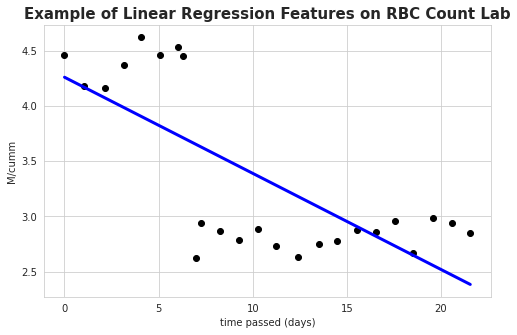

In [553]:
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

print('Slope: {}'.format(reg.coef_[0][0]))
print('Intercept: {}'.format(reg.intercept_[0]))

yval = (np.dot(slope, x) + intercept) / 1000000

# Plot outputs
plt.figure(figsize = (8,5))
plt.title('Example of Linear Regression Features on RBC Count Lab',weight='bold', fontsize=15)
plt.scatter(x/1440, y / 1000000, color="black")
plt.plot(x/1440, yval, color="blue", linewidth=3)
plt.xlabel('time passed (days)')
plt.ylabel('M/cumm')

plt.show()

In [445]:
def perc25(x):
    return np.percentile(x, 25)

def perc75(x):
    return np.percentile(x, 75)

labstable = df_labs_num_cleaned.groupby('lab_custom_group', as_index = False)['converted_SI_ord_num_value'].agg([perc25, np.median, perc75, np.mean, np.std])
labstable = labstable.applymap(lambda x: round(x,2)).reset_index()
labstable.columns = ['lab_custom_group','25th percentile','median','75th percentile','mean','std',]
labstable['mean ± std'] = labstable['mean'].astype(str) + ' ± ' + labstable['std'].astype(str)
labstable = labstable.drop(['mean','std'], axis = 1)
labstable = labstable.merge(units, how = 'left', on = 'lab_custom_group')
labstable['lab_custom_group'] = labstable['lab_custom_group'].str.replace('_',' ')
#labstable
labstable.to_csv('labstable.csv', index = False)

### 4. Cleaning categorical labs
Create dictionary to look at unique values in each lab custom group.

In [81]:
lab_cat_dict = {}
names = df_labs_categorical['lab_custom_group'].unique()
for key in names:
    values = list(df_labs_categorical[df_labs_categorical['lab_custom_group'] == key]['ord_value'].unique())
    lab_cat_dict[key] = values
print(lab_cat_dict)

{'blood_group_rh_type': ['A Negative', 'A Positive', 'AB Positive', 'O Negative', 'O Positive', 'B Positive', 'B Negative', 'AB Negative', 'see'], 'mixed_mrsa_surv_culture': ['Negative for Methicillin Resistant Staphylococcus aureus', 'Negative for Methicillin Resistant Staph aureus', 'Negative for Methicillin Resistant Staph.aureus', 'Methicillin resistant Staphylococcus aureus', nan]}


In [82]:
def clean_cat_labs(df_labs_input, lab_name):
    '''
    This function cleans categorical labs by inspecting each lab manually first-hand and re-generating new categories.
    Returns cleaned subset of each lab group in the whole labs dataframe.
    
    Runtime: 0.04 sec/lab
    '''
    if lab_name == 'blood_group_rh_type':
        cur_lab_subset = df_labs_input[df_labs_input['lab_custom_group'] == lab_name].copy()
        cur_lab_subset['corrected_ord_value'] = cur_lab_subset['ord_value'].str.lower()
        cur_lab_subset = cur_lab_subset[cur_lab_subset['corrected_ord_value'] != 'see']
        #cur_lab_subset = cur_lab_subset[cur_lab_subset['corrected_ord_value'].str.contains('pos|neg')]
        #cur_lab_subset.loc[cur_lab_subset['corrected_ord_value'].str.contains('pos'), 'corrected_ord_value'] = 'positive'
        #cur_lab_subset.loc[cur_lab_subset['corrected_ord_value'].str.contains('neg'), 'corrected_ord_value'] = 'negative'
        return cur_lab_subset

    elif lab_name == 'mixed_mrsa_surv_culture':
        cur_lab_subset = df_labs_input[df_labs_input['lab_custom_group'] == lab_name].copy()
        cur_lab_subset['corrected_ord_value'] = cur_lab_subset['ord_value'].str.lower()
        cur_lab_subset = cur_lab_subset[~cur_lab_subset['corrected_ord_value'].isnull()]
        cur_lab_subset['corrected_ord_value'] = cur_lab_subset['corrected_ord_value'].apply(lambda x: 'negative' if 'neg' in x else 'positive')
        return cur_lab_subset
    else:
        print('No pre-processing in place for: ', lab_name)
        return cur_lab_subset

## Feature Engineering

In [83]:
def get_linreg_stats(offsets : pd.Series, results : pd.Series):
    '''
    This row-wise function calculates applies linear regression on the cumulated time(sec) and values per lab.
    '''
    get_relative_time = offsets.to_frame()
    get_relative_time['previous_time'] = get_relative_time['specimen_taken_time'].shift(periods = 1)
    get_relative_time['time_diff'] = round((get_relative_time['specimen_taken_time'] - get_relative_time['previous_time']).dt.total_seconds(), 2) / 60
    get_relative_time['relative_time'] = get_relative_time['time_diff'].cumsum().fillna(0)

    x = get_relative_time['relative_time'].values.reshape(len(get_relative_time), 1)
    y = results.values.reshape(len(get_relative_time), 1)
    
    reg = LinearRegression().fit(x, y)
    
    slope = reg.coef_
    intercept = reg.intercept_
    return slope[0][0], intercept[0]

#     try:
#         linreg = stats.linregress(x, y)
#         return float(linreg.slope), float(linreg.intercept)
#     except ValueError:
#         return 0, float(x.mean())
    

def df_linreg(df):
    return get_linreg_stats(df[df.columns[0]], df[df.columns[1]])

In [388]:
def get_labs_num_feat(df_labs_input):
    '''
    Calculates statistical and linear regression features for each lab group present per ICU hospital stay.
    
    Runtime: 483.41 sec
    '''    
    # Get simple statistical features
    result_df = df_labs_num_cleaned.groupby(['osler_sid','pat_enc_csn_sid', 'lab_custom_group'])['converted_SI_ord_num_value'].agg(['last', 'mean', 'var', 'median', 'min', 'max'])
    result_df.reset_index(inplace = True)
    
    # Get linear regression features
    linreg_df = df_labs_num_cleaned.groupby(['osler_sid','pat_enc_csn_sid', 'lab_custom_group'])[['specimen_taken_time', 'converted_SI_ord_num_value']].apply(df_linreg)
    result_df[['slope', 'intercept']] = pd.DataFrame(linreg_df.to_list(), columns = ['slope', 'intercept'])
    
    # Convert statistical features from rows to columns
    full_num_data = result_df.pivot(index = ['osler_sid','pat_enc_csn_sid'], 
                columns = 'lab_custom_group', 
                values = ['last','mean','var','median','min','max','slope','intercept'])
    full_num_data.columns = ['_'.join(col) for col in full_num_data.columns.values]
    full_num_data = full_num_data.reset_index()
    
    # Merge on hosp stays in our cohort
    output = pd.merge(left = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']], right = full_num_data, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
    
    return output

In [389]:
def get_labs_cat_feat(df_labs_input):
    '''
    Calculates one hot encoded features for each lab group present in each hospital stay w/ ICU.
    '''
    result = CHF_hosp_icu_stays.copy()
    for lab_name in df_labs_input['lab_custom_group'].unique():
        # print(lab_name)
        # clean categorical labs
        cleaned_df =  clean_cat_labs(df_labs_input, lab_name)
        
        # create one hot encoded features for each lab group
        onehot = pd.get_dummies(cleaned_df['corrected_ord_value'], prefix = lab_name)
        cleaned_df = pd.concat([cleaned_df.loc[:, 'osler_sid':'labels'], onehot], axis = 1)
        
        # group one hot encoded features by each hospital stay that has present lab group documented
        grouped = cleaned_df.groupby(['osler_sid','pat_enc_csn_sid'], as_index = False)[cleaned_df.columns[5:]].max()
        
        # merge on hospital stays in our cohort, fill nan values w/ 0s
        merged = pd.merge(left = CHF_hosp_icu_stays[['osler_sid','pat_enc_csn_sid']], right = grouped, how = 'left', on = ['osler_sid','pat_enc_csn_sid']).fillna(0)
        result = result.merge(merged, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
    return result

In [390]:
# Calc features
df_num_features = get_labs_num_feat(df_labs_num_cleaned)
df_cat_features = get_labs_cat_feat(df_labs_categorical) 

# Merge both num and cat labs features into one
temp = CHF_hosp_icu_stays.merge(df_num_features, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
labs_features = temp.merge(df_cat_features, how = 'left', on = ['osler_sid','pat_enc_csn_sid'])
labs_features.to_csv('labs_features.csv', index = False)

labs_features.head()

,osler_sid,pat_enc_csn_sid,hosp_admsn_time_x,hosp_disch_time_x,labels_x,last_blood_act_partial_thromboplastin_time,last_blood_alanine_amino_trans,last_blood_albumin,last_blood_alkaline_phosphate,last_blood_anion_gap,...,blood_group_rh_type_a negative,blood_group_rh_type_a positive,blood_group_rh_type_ab negative,blood_group_rh_type_ab positive,blood_group_rh_type_b negative,blood_group_rh_type_b positive,blood_group_rh_type_o negative,blood_group_rh_type_o positive,mixed_mrsa_surv_culture_negative,mixed_mrsa_surv_culture_positive
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,55.8,0.5478,36.0,2.0584,13.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,2016-09-01 10:49:00,2016-09-23 17:03:00,1.0,25.3,0.2490,30.0,1.7596,12.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,2019-07-16 17:06:00,2019-07-27 17:01:00,1.0,22.6,0.1328,35.0,1.0790,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,2018-03-22 00:39:00,2018-03-31 19:23:00,0.0,23.3,NaN,NaN,NaN,11.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,2016-09-25 10:04:00,2016-10-13 14:19:00,0.0,24.4,0.4482,30.0,1.9754,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [391]:
df_num_features

,osler_sid,pat_enc_csn_sid,last_blood_act_partial_thromboplastin_time,last_blood_alanine_amino_trans,last_blood_albumin,last_blood_alkaline_phosphate,last_blood_anion_gap,last_blood_aptt_ratio,last_blood_aspartate_amino_trans,last_blood_base_excess,...,intercept_blood_po2_arterial,intercept_blood_potassium,intercept_blood_protein_total,intercept_blood_prothrombin_time,intercept_blood_rbc_count,intercept_blood_rbc_distribution_width,intercept_blood_sodium,intercept_blood_temp_adjust_res,intercept_blood_urea_nitrogen,intercept_blood_wbc_count
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,55.8,0.5478,36.0,2.0584,13.0,2.1,0.6308,1.0,...,175.497309,4.091395,68.479329,8.705595,4.259463e+06,15.465625,140.157136,37.224236,8.482758,8922.256335
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,25.3,0.2490,30.0,1.7596,12.0,1.0,0.6474,1.0,...,263.474881,5.181390,69.642631,10.430062,2.490277e+06,14.387211,143.371253,36.691418,21.290685,6031.402136
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,22.6,0.1328,35.0,1.0790,16.0,0.9,0.3486,1.0,...,264.113319,4.373126,68.301884,10.300000,4.446217e+06,23.391637,141.797522,36.892175,6.021021,17479.705105
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,23.3,NaN,NaN,NaN,11.0,0.9,NaN,NaN,...,NaN,4.554169,NaN,11.400000,4.411179e+06,13.113119,138.716185,NaN,6.610235,11512.511988
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,24.4,0.4482,30.0,1.9754,12.0,0.9,0.3652,1.0,...,176.836665,4.382577,51.578355,12.132841,4.082685e+06,17.187863,137.502021,36.827070,8.076929,16366.671521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,23.7,NaN,NaN,NaN,14.0,0.9,NaN,NaN,...,NaN,4.421581,NaN,11.966152,4.690000e+06,13.600000,136.399999,NaN,6.598787,5310.000000
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,62.8,0.2656,31.0,2.5730,15.0,2.4,0.3320,2.0,...,147.052197,3.793576,47.424965,8.327117,2.799726e+06,14.594360,144.253516,37.062444,6.418954,14904.581508
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,24.3,0.2490,37.0,1.0790,11.0,0.9,0.4150,6.0,...,124.000000,4.370624,59.000000,10.600000,3.913428e+06,14.169219,139.647685,37.000000,9.112237,7461.483990
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,37.9,0.1826,30.0,3.4860,13.0,1.4,0.2490,3.0,...,108.453343,4.115243,51.779380,15.540132,2.715173e+06,27.893332,135.509410,36.383405,7.798828,10288.788530


In [387]:
cols = df_num_features.columns[df_num_features.columns.str.contains('^mean_')]
df_num_features[cols]

,mean_blood_act_partial_thromboplastin_time,mean_blood_alanine_amino_trans,mean_blood_albumin,mean_blood_alkaline_phosphate,mean_blood_anion_gap,mean_blood_aptt_ratio,mean_blood_aspartate_amino_trans,mean_blood_base_excess,mean_blood_basophil_percentage,mean_blood_bilirubin_total,...,mean_blood_po2_arterial,mean_blood_potassium,mean_blood_protein_total,mean_blood_prothrombin_time,mean_blood_rbc_count,mean_blood_rbc_distribution_width,mean_blood_sodium,mean_blood_temp_adjust_res,mean_blood_urea_nitrogen,mean_blood_wbc_count
0,56.640000,17.050000,3.600000,79.300000,16.193548,2.142222,32.850000,2.977778,0.822222,3.495000,...,138.000000,4.094030,6.125000,14.187500,3.349167,17.270833,138.173077,37.213333,26.161290,11.608750
1,26.450000,27.062500,3.568750,86.187500,13.880000,1.025000,32.687500,2.600000,0.566667,0.281250,...,180.200000,4.389855,6.268750,10.260000,2.540370,15.674074,139.723404,36.440000,42.560000,10.071481
2,43.525000,13.000000,4.000000,85.833333,16.636364,1.650000,21.166667,3.187500,0.640000,0.216667,...,211.125000,4.072727,6.250000,10.100000,3.697500,25.433333,137.714286,36.956250,14.545455,16.320833
3,28.000000,NaN,NaN,NaN,12.833333,1.050000,NaN,NaN,0.109091,NaN,...,NaN,4.275000,NaN,11.700000,4.297500,13.325000,135.700000,NaN,18.333333,14.935000
4,73.725000,29.263158,2.815789,91.789474,14.482759,2.800000,27.263158,2.862745,0.164286,0.594737,...,126.040000,4.251163,4.863158,12.425000,3.356364,20.536364,141.707692,36.958824,38.586207,15.498636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,24.866667,NaN,NaN,NaN,14.000000,0.933333,NaN,NaN,0.400000,NaN,...,NaN,4.233333,NaN,11.666667,4.690000,13.600000,136.000000,NaN,16.500000,5.310000
4484,64.568182,22.666667,3.211765,98.555556,15.368421,2.443182,54.055556,3.677966,0.400000,0.752941,...,151.750000,3.866154,5.847059,15.766667,2.725000,15.744444,139.725000,37.052542,16.631579,12.805000
4485,24.300000,15.500000,3.800000,66.000000,12.888889,0.900000,24.500000,6.000000,0.300000,1.200000,...,100.500000,4.241667,5.800000,10.600000,3.511429,14.028571,139.454545,37.000000,23.222222,6.220000
4486,46.101562,14.704762,2.615888,191.830189,12.468254,1.703125,39.971154,3.534413,0.639394,2.696226,...,132.979592,4.425000,4.777570,12.961290,2.660965,23.473684,138.608187,36.487121,28.031746,12.014211


In [87]:
print(time.time() - st)
print(time.time() - st1)

1546.9990272521973


## Data Visualization

### Lab Prevalence in our cohort

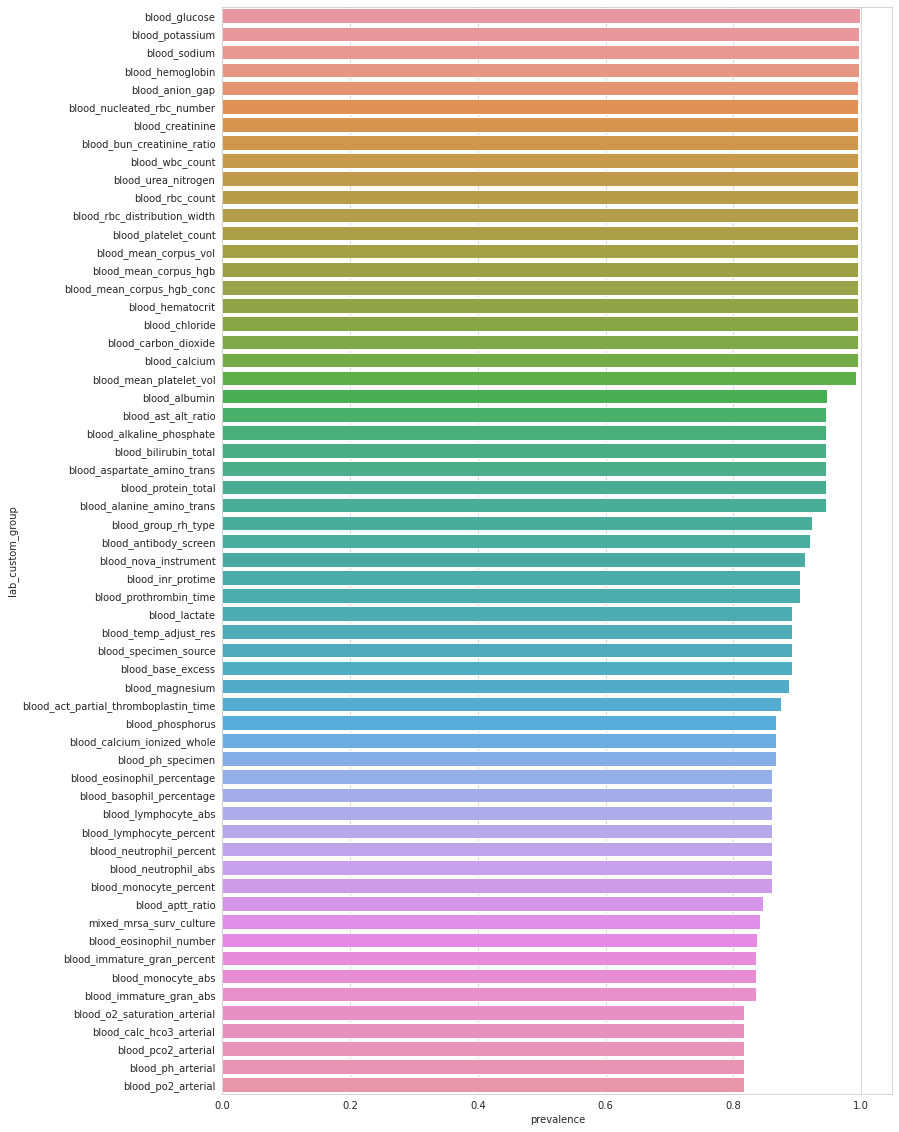

In [175]:
df = labs_prevalence[labs_prevalence['prevalence'] >= 0.8].drop('num_stays', axis = 1).sort_values('prevalence', ascending = False)

sns.set_style('whitegrid')
plt.figure(figsize = (12, 20))
sns.barplot(x="prevalence", y="lab_custom_group", data = df)
plt.show()

## Statistical Analysis

### 1. Summary Statistics

In [522]:
grouped = df_labs_num_cleaned.groupby(['pat_enc_csn_sid','lab_custom_group'])['converted_SI_ord_num_value'].agg(['mean','std','median'])
# full_num_data = grouped.pivot(index = 'pat_enc_csn_sid',columns = 'lab_custom_group', values = ['mean','std','median'])
# full_num_data.columns = ['_'.join(col) for col in full_num_data.columns.values]
# full_num_data = full_num_data.reset_index()

In [523]:
full_num_data = grouped.pivot_table(index = 'pat_enc_csn_sid',columns = 'lab_custom_group')
full_num_data.columns = ['_'.join(col) for col in full_num_data.columns.values]
full_num_data = full_num_data.reset_index()
df = pd.merge(left = CHF_hosp_icu_stays, right = full_num_data, how = 'left', on = 'pat_enc_csn_sid')
df

,osler_sid,pat_enc_csn_sid,hosp_admsn_time,hosp_disch_time,labels,mean_blood_act_partial_thromboplastin_time,mean_blood_alanine_amino_trans,mean_blood_albumin,mean_blood_alkaline_phosphate,mean_blood_anion_gap,...,std_blood_po2_arterial,std_blood_potassium,std_blood_protein_total,std_blood_prothrombin_time,std_blood_rbc_count,std_blood_rbc_distribution_width,std_blood_sodium,std_blood_temp_adjust_res,std_blood_urea_nitrogen,std_blood_wbc_count
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,0.0,56.640000,0.283030,36.000000,1.316380,16.193548,...,81.529770,0.377343,11.733331,3.237669,772696.670711,1.364927,4.310139,0.306446,3.103686,3013.327371
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,2016-09-01 10:49:00,2016-09-23 17:03:00,1.0,26.450000,0.449237,35.687500,1.430712,13.880000,...,129.085501,0.813877,6.321590,0.403733,267574.310045,1.184058,4.073788,0.775672,5.292715,5049.836025
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,2019-07-16 17:06:00,2019-07-27 17:01:00,1.0,43.525000,0.215800,40.000000,1.424833,16.636364,...,140.660115,0.256685,6.655825,0.282843,630730.096432,1.427224,2.552310,0.270724,1.027103,4904.863001
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,2018-03-22 00:39:00,2018-03-31 19:23:00,0.0,28.000000,NaN,NaN,NaN,12.833333,...,NaN,0.384057,NaN,0.424264,288416.523294,0.205050,2.129986,NaN,0.796077,4063.081007
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,2016-09-25 10:04:00,2016-10-13 14:19:00,0.0,73.725000,0.485768,28.157895,1.523705,14.482759,...,67.675082,0.542054,10.139091,0.221736,803341.506308,2.245322,4.122056,0.534107,5.778212,5888.883228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,2017-02-04 00:58:00,2017-02-05 16:15:00,1.0,24.866667,NaN,NaN,NaN,14.000000,...,NaN,0.450925,NaN,0.416333,NaN,NaN,4.082483,NaN,0.618515,NaN
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,2018-09-15 15:35:00,2018-10-03 16:09:00,0.0,64.568182,0.376267,32.117647,1.636022,15.368421,...,118.525796,0.468467,11.242318,5.239780,546843.885670,1.070031,6.063711,0.442312,1.409480,4558.523045
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,2016-10-19 06:33:00,2016-10-24 11:28:00,0.0,24.300000,0.257300,38.000000,1.095600,12.888889,...,33.234019,0.439955,1.414214,NaN,413740.199136,0.197605,1.293340,0.000000,1.167801,1297.317746
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,2020-06-19 21:44:00,2020-09-03 14:17:00,1.0,46.101562,0.244099,26.158879,3.184381,12.468254,...,65.631544,0.685408,6.469534,2.148748,547256.988212,4.467980,3.588174,0.482690,6.211148,8652.320973


In [524]:
cols = labs_features.columns[labs_features.columns.str.contains('^mean_')].to_list()
cols.append('labels_x') # Change

df = labs_features[cols]
df0 = df[df.labels_x == 0]
df1 = df[df.labels_x == 1]

In [526]:
df1

,mean_blood_act_partial_thromboplastin_time,mean_blood_alanine_amino_trans,mean_blood_albumin,mean_blood_alkaline_phosphate,mean_blood_anion_gap,mean_blood_aptt_ratio,mean_blood_aspartate_amino_trans,mean_blood_base_excess,mean_blood_basophil_percentage,mean_blood_bilirubin_total,...,mean_blood_potassium,mean_blood_protein_total,mean_blood_prothrombin_time,mean_blood_rbc_count,mean_blood_rbc_distribution_width,mean_blood_sodium,mean_blood_temp_adjust_res,mean_blood_urea_nitrogen,mean_blood_wbc_count,labels_x
1,26.450000,0.449237,35.687500,1.430712,13.880000,1.025000,0.542612,2.600000,0.566667,4.809375,...,4.389855,62.687500,10.260000,2.540370e+06,15.674074,139.723404,36.440000,15.198176,10071.481481,1.0
2,43.525000,0.215800,40.000000,1.424833,16.636364,1.650000,0.351367,3.187500,0.640000,3.705000,...,4.072727,62.500000,10.100000,3.697500e+06,25.433333,137.714286,36.956250,5.194182,16320.833333,1.0
5,21.750000,0.369350,30.000000,1.157850,11.250000,0.800000,0.394250,NaN,0.500000,14.962500,...,4.180000,48.250000,12.800000,3.356000e+06,16.920000,135.200000,NaN,6.963450,8350.000000,1.0
8,51.285714,0.269750,32.187500,0.921300,12.941176,1.933333,0.320588,2.571429,0.175000,6.733125,...,4.152381,58.250000,10.443750,3.055556e+06,14.405556,142.142857,37.200000,6.301765,18016.111111,1.0
9,32.627778,0.768630,35.030303,1.171338,15.243902,1.233333,0.325913,4.000000,0.533333,17.151818,...,4.167123,65.181818,13.877778,3.710357e+06,16.028571,131.285714,36.735714,21.243095,10270.357143,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4462,65.362766,0.170905,33.857143,1.877644,16.094737,2.469149,0.378821,1.333333,0.264286,14.168571,...,4.034677,56.062500,16.932143,2.730161e+06,19.337097,138.690722,36.566667,14.864287,5554.516129,1.0
4468,24.100000,0.588114,29.285714,1.071886,12.866667,0.900000,0.456500,2.875000,0.250000,7.084286,...,4.361765,54.142857,11.366667,3.421333e+06,14.206667,136.793103,36.812500,4.689913,18921.333333,1.0
4477,71.733333,0.392364,33.125000,1.448727,18.833333,2.716667,1.863727,2.423077,1.225000,7.790000,...,4.903226,63.125000,10.600000,2.481538e+06,15.692308,135.727273,36.938462,10.921308,12741.538462,1.0
4483,24.866667,NaN,NaN,NaN,14.000000,0.933333,NaN,NaN,0.400000,NaN,...,4.233333,NaN,11.666667,4.690000e+06,13.600000,136.000000,NaN,5.892150,5310.000000,1.0


In [362]:
labstable = pd.concat([labs_features[cols].mean(), labs_features[cols].std()], axis = 1)
labstable = labstable.reset_index()
labstable.columns = ['lab_custom_group','mean','std']
labstable['lab_custom_group'] = labstable['lab_custom_group'].str.replace('mean_','')
labstable = labstable.iloc[:len(labstable)-1, :]
labstable['mean ± std'] = round(labstable['mean'], 2).astype(str) + ' ± '+ round(labstable['std'], 2).astype(str)
labstable = labstable.drop(['mean','std'], axis = 1)
units = df_labs_num_cleaned[['lab_custom_group','reference_SI_unit']].drop_duplicates()
result = pd.merge(left = labstable, right = units, how = 'left', on = 'lab_custom_group')
result['lab_custom_group'] = result['lab_custom_group'].str.replace('_',' ')
result = result.rename({'lab_custom_group':'lab group'}, axis = 1)
display(result)
result.to_csv('labstable.csv',index=False)

,lab group,mean ± std,reference_SI_unit
0,blood act partial thromboplastin time,40.72 ± 18.09,Seconds
1,blood alanine amino trans,66.77 ± 249.83,µkat/L
2,blood albumin,3.21 ± 0.52,g/L
3,blood alkaline phosphate,103.9 ± 90.44,µkat/L
4,blood anion gap,13.93 ± 2.59,mmol/L
5,blood aptt ratio,1.52 ± 0.68,PatAptt/Normal
6,blood aspartate amino trans,108.9 ± 497.59,µkat/L
7,blood base excess,3.43 ± 2.36,mmol/L
8,blood basophil percentage,0.39 ± 0.3,%
9,blood bilirubin total,0.98 ± 1.73,µmol/L


### 2. Mann-Whitney U test on different numerical lab groups

In [273]:
### Check distribution -> labs in both labels are NOT NORMALLY DISTRIBUTED
w, pvalue = stats.shapiro(df0.mean())
print(w, pvalue)

w, pvalue = stats.shapiro(df1.mean())
print(w, pvalue)


0.719085693359375 1.851464048741036e-08
0.7039626836776733 9.75499681032943e-09


In [544]:
# Perform Mann-Whitney U test
df0 = df0.fillna(0)
df1 = df1.fillna(0)

pvalues = []

for col in df0.columns:
    _, pvalue = stats.mannwhitneyu(x=df0[col], y=df1[col], alternative = 'two-sided')
    pvalues.append(pvalue)

lab_stat_table = pd.concat([df0.median(), df1.median()], axis = 1)
lab_stat_table['p-value'] = pvalues
lab_stat_table = lab_stat_table.drop('labels_x', axis = 0)
lab_stat_table = lab_stat_table.applymap(lambda x: round(x, 3)).reset_index()
lab_stat_table.columns = ['lab group','label 0: median','label 1: median','p-value']
lab_stat_table.head()
# lab_stat_table.to_csv('lab_stat_table.csv', index = False)

,lab group,label 0: median,label 1: median,p-value
0,mean_blood_act_partial_thromboplastin_time,30.014,31.167,0.106
1,mean_blood_alanine_amino_trans,0.324,0.319,0.543
2,mean_blood_albumin,31.930,32.124,0.285
3,mean_blood_alkaline_phosphate,1.332,1.318,0.594
4,mean_blood_anion_gap,13.667,13.818,0.163
